# CNN + LSTM ile RF Sinyal Mod√ºlasyon Sƒ±nƒ±flandƒ±rmasƒ± (RadioML 2018.01A)
Derin √∂ƒürenme ile kablosuz ileti≈üim sinyallerinin doƒüru ve hƒ±zlƒ± sƒ±nƒ±flandƒ±rƒ±lmasƒ±


## üìñ Giri≈ü

Kablosuz ileti≈üim sistemlerinde, alƒ±nan sinyallerin hangi mod√ºlasyon tekniƒüiyle g√∂nderildiƒüini tespit etmek √ßok √∂nemlidir. Bu projede, **RadioML 2018.01A** veri setinden se√ßilen 8 mod√ºlasyon sƒ±nƒ±fƒ±nƒ± sƒ±nƒ±flandƒ±rmak i√ßin **CNN + LSTM tabanlƒ± bir derin √∂ƒürenme modeli** kullanƒ±lmƒ±≈ütƒ±r.

Ama√ß, I/Q (In-phase/Quadrature) √∂rneklerinden uzamsal ve zamansal √∂zellikleri √ßƒ±kararak y√ºksek doƒürulukta sƒ±nƒ±flandƒ±rma yapmaktƒ±r.

> Sonu√ß: Model test verisinde **%90.66 doƒüruluk** elde etmi≈ütir.


## üß† Yakla≈üƒ±m

- **Veri Seti**: RadioML 2018.01A
- **Se√ßilen Sƒ±nƒ±flar**: 8 farklƒ± mod√ºlasyon t√ºr√º (BPSK, 16QAM, FM, AM-DSB-WC vb.)
- **Model Mimarisi**:
  - I ve Q bile≈üenleri i√ßin ayrƒ± CNN dallarƒ±
  - √ñzelliklerin birle≈ütirilip LSTM‚Äôe verilmesi
  - Fully-connected katmanlar ve dropout ile d√ºzenleme
- **Kayƒ±p Fonksiyonu**: Categorical Crossentropy
- **Optimizasyon**: Adam (lr=0.0001)
- **Ba≈üarƒ± √ñl√ß√ºt√º**: Doƒüruluk (Accuracy)


## üß™ Veri √ñn ƒ∞≈üleme

- Her mod√ºlasyon sƒ±nƒ±fƒ±nda toplam 106,496 √∂rnek bulunmakta.
- Veri setinden yalnƒ±zca **d√º≈ü√ºk SNR seviyelerini** temsil eden 4.096 x 4 √∂rnek se√ßilmi≈ütir.
- Veriler (1024,) formatƒ±ndan (32, 32, 2) ≈üekline getirilerek 2D CNN'e uygun hale getirilmi≈ütir.
- Etiketler one-hot encoding formatƒ±na d√∂n√º≈üt√ºr√ºlm√º≈üt√ºr.


## üß± Model Mimarisi

Model ≈üu yapƒ±lardan olu≈üur:
- I ve Q sinyalleri i√ßin ayrƒ± **2D CNN dallarƒ±**
- Uzamsal √∂zelliklerin birle≈ütirilmesi ve **LSTM**'e aktarƒ±lmasƒ±
- **Tam baƒülantƒ±lƒ± (Dense) katmanlar** ve **dropout** ile genelleme kabiliyetinin artƒ±rƒ±lmasƒ±
- √áƒ±kƒ±≈üta softmax ile 8 sƒ±nƒ±f tahmini yapƒ±lƒ±r

‚úÖ Sonu√ß: Test doƒüruluƒüu **%90.66**


In [1]:
# gerekli kutuphanelerin yuklenmesi
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import keras
import tensorflow.keras as tk
from keras.layers import ReLU


2025-07-09 05:37:18.730439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752039438.912871      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752039438.968724      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# veri dosyasini HDF5 formatinda acma islemi
file = h5py.File("/kaggle/input/radioml2018/GOLD_XYZ_OSC.0001_1024.hdf5", "r")

# siniflar
all_classes = ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK',
               '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM',
               '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC',
               'FM', 'GMSK', 'OQPSK']

# sinyal tipi √ße≈üitliliƒüi a√ßƒ±sƒ±ndan dengeli olacak sekilde bu siniflardan bazilarini seciyoruz
chosen_classes = ['4ASK', 'BPSK', 'QPSK', '16PSK', '16QAM', 'FM', 'AM-DSB-WC', '32APSK']
class_indices = [all_classes.index(cls) for cls in chosen_classes]


In [3]:
# tum siniflardan belirli sayida ornek aliyoruz
features, labels = [], []
snr_count = 4

for class_id in class_indices:
    start = (106496 * (class_id + 1)) - 4096 * snr_count
    end = 106496 * (class_id + 1)
    features.append(file['X'][start:end])
    labels.append(file['Y'][start:end])

# dizi haline getirip sekillendiriyoruz
X = np.concatenate(features).reshape(-1, 32, 32, 2)
Y_raw = np.concatenate(labels)
Y_df = pd.DataFrame(Y_raw)

# sadece secili siniflar kaliyor
non_zero_cols = Y_df.columns[Y_df.sum() > 0]
Y_df = Y_df[non_zero_cols]
Y_df.columns = chosen_classes


In [4]:
# egitim ve test kumeleri
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_df, test_size=0.2, random_state=42)


In [5]:
# CNN + LSTM Modeli
def build_model():
    input_i = keras.Input(shape=(32, 32, 1))
    input_q = keras.Input(shape=(32, 32, 1))
    
    def cnn_branch(input_layer):
        x = tk.layers.Conv2D(48, 3, activation=ReLU())(input_layer)
        x = tk.layers.Conv2D(48, 3, activation=ReLU())(x)
        x = tk.layers.MaxPool2D(pool_size=2)(x)
        x = tk.layers.Conv2D(96, 3, activation=ReLU())(x)
        x = tk.layers.Conv2D(96, 3, activation=ReLU())(x)
        x = tk.layers.MaxPool2D(pool_size=2)(x)
        return tk.layers.Flatten()(x)

    branch_i = cnn_branch(input_i)
    branch_q = cnn_branch(input_q)
    merged = keras.layers.Concatenate()([branch_i, branch_q])

    lstm_input = keras.layers.Reshape((1, -1))(merged)
    lstm_output = tk.layers.LSTM(128, dropout=0.4, recurrent_dropout=0.4)(lstm_input)

    x = tk.layers.Dense(512, activation=ReLU())(lstm_output)
    x = tk.layers.Dropout(0.4)(x)
    x = tk.layers.Dense(256, activation=ReLU())(x)
    x = tk.layers.Dropout(0.4)(x)

    output = tk.layers.Dense(len(chosen_classes), activation='softmax')(x)

    model = keras.Model(inputs=[input_i, input_q], outputs=output)
    model.compile(optimizer=tk.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()


I0000 00:00:1752039640.333625      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752039640.334383      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
# egitim sirasinda erken durdurma ve model kaydetme
callbacks = [
    tk.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    tk.callbacks.ModelCheckpoint("best_model_rf.weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
]

history = model.fit(
    [X_train[:,:,:,0], X_train[:,:,:,1]],
    Y_train,
    validation_data=([X_test[:,:,:,0], X_test[:,:,:,1]], Y_test),
    batch_size=64,
    epochs=25,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/25


I0000 00:00:1752039672.782525     102 cuda_dnn.cc:529] Loaded cuDNN version 90300



Epoch 1: val_loss improved from inf to 0.79405, saving model to best_model_rf.weights.h5
1639/1639 - 45s - 28ms/step - accuracy: 0.5744 - loss: 0.9020 - val_accuracy: 0.6015 - val_loss: 0.7941
Epoch 2/25

Epoch 2: val_loss improved from 0.79405 to 0.77420, saving model to best_model_rf.weights.h5
1639/1639 - 32s - 20ms/step - accuracy: 0.6029 - loss: 0.8003 - val_accuracy: 0.6093 - val_loss: 0.7742
Epoch 3/25

Epoch 3: val_loss improved from 0.77420 to 0.50139, saving model to best_model_rf.weights.h5
1639/1639 - 33s - 20ms/step - accuracy: 0.6755 - loss: 0.6781 - val_accuracy: 0.7760 - val_loss: 0.5014
Epoch 4/25

Epoch 4: val_loss improved from 0.50139 to 0.46845, saving model to best_model_rf.weights.h5
1639/1639 - 33s - 20ms/step - accuracy: 0.7755 - loss: 0.5070 - val_accuracy: 0.7924 - val_loss: 0.4685
Epoch 5/25

Epoch 5: val_loss improved from 0.46845 to 0.44577, saving model to best_model_rf.weights.h5
1639/1639 - 33s - 20ms/step - accuracy: 0.7907 - loss: 0.4757 - val_accura

## üìà Eƒüitim Sonu√ßlarƒ±

Eƒüitim s√ºreci boyunca:
- Doƒüruluk ve kayƒ±p deƒüerleri takip edildi
- A≈üƒ±rƒ± √∂ƒürenmeyi engellemek i√ßin **early stopping** ve **model checkpoint** kullanƒ±ldƒ±

A≈üaƒüƒ±da eƒüitim sonu√ßlarƒ±na ait grafikler yer almaktadƒ±r.


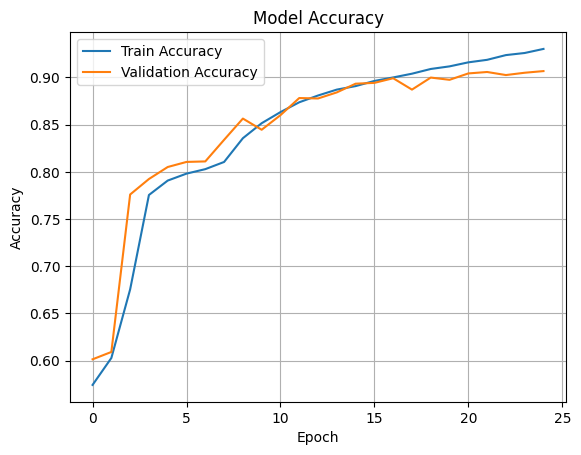

In [7]:
# dogruluk
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(); plt.grid(); plt.show()


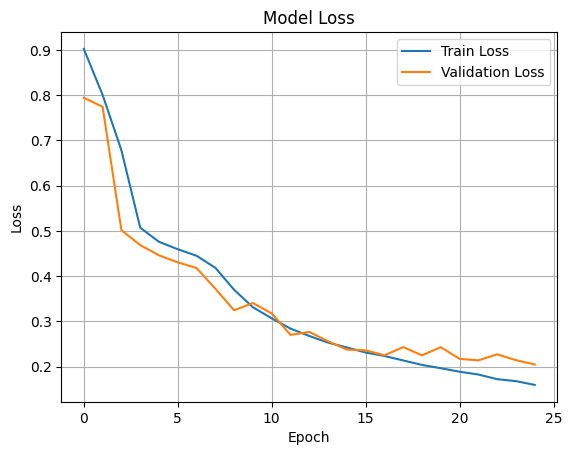

In [8]:
# kayip (Loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(); plt.grid(); plt.show()


## üîç Karma≈üƒ±klƒ±k Matrisi

A≈üaƒüƒ±daki matriste modelin hangi mod√ºlasyon sƒ±nƒ±flarƒ±nƒ± ne kadar doƒüru tahmin ettiƒüi g√∂sterilmektedir.

Bazƒ± benzer mod√ºlasyonlar (√∂rneƒüin AM ve FM) arasƒ±nda karƒ±≈üƒ±klƒ±k olmasƒ± doƒüaldƒ±r. Buna raƒümen genel sƒ±nƒ±flandƒ±rma ba≈üarƒ±mƒ± olduk√ßa y√ºksek seviyededir.

Bu t√ºr analizler √∂zellikle:
- Askeri haberle≈üme sistemlerinde
- Spektrum izleme √ß√∂z√ºmlerinde
- Otonom sinyal tanƒ±mlayƒ±cƒ±larda √∂nemlidir.


820/820 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 5ms/step


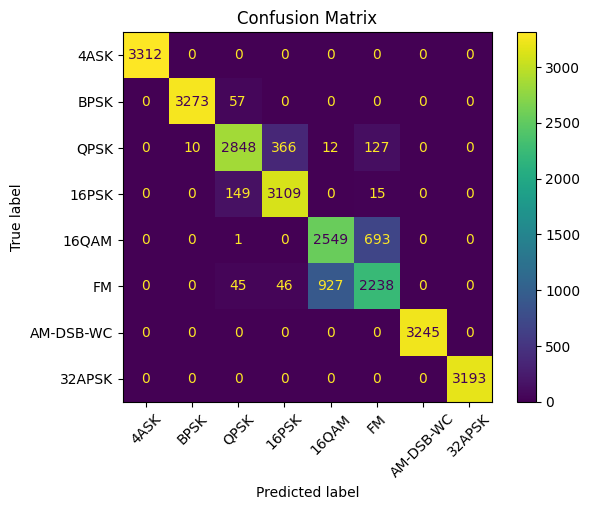

In [9]:
# tahmin ve sinif eslesmeleri
pred_probs = model.predict([X_test[:,:,:,0], X_test[:,:,:,1]])
y_true = np.argmax(Y_test.values, axis=1)
y_pred = np.argmax(pred_probs, axis=1)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=chosen_classes).plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False); plt.show()


In [10]:
# agirliklari kaydediyoruz
model.save_weights('/kaggle/working/custom_rf_model.weights.h5')


In [11]:
# agirliklari geri y√ºkleyip test ediyoruz
restored_model = build_model()
restored_model.load_weights('/kaggle/working/custom_rf_model.weights.h5')
loss, acc = restored_model.evaluate([X_test[:,:,:,0], X_test[:,:,:,1]], Y_test, verbose=0)
print(f"Y√ºklenen model doƒüruluƒüu: %{acc*100:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Y√ºklenen model doƒüruluƒüu: %90.66


## üí¨ Sonu√ß ve Gelecek √áalƒ±≈ümalar

Bu proje, RF sinyallerinin sƒ±nƒ±flandƒ±rƒ±lmasƒ±nda derin √∂ƒürenmenin g√ºc√ºn√º g√∂stermektedir. CNN + LSTM tabanlƒ± modelimiz, d√º≈ü√ºk SNR ko≈üullarƒ±nda dahi y√ºksek doƒüruluk saƒülamƒ±≈ütƒ±r.

### Geli≈ütirme Fikirleri:
- 24 mod√ºlasyon sƒ±nƒ±fƒ±nƒ±n tamamƒ±nƒ± dahil etmek
- Transformer tabanlƒ± alternatif yapƒ±larƒ± denemek
- Ger√ßek zamanlƒ± g√∂m√ºl√º sistemlere (Jetson, FPGA) entegrasyon

### Uygulama Alanlarƒ±:
- Akƒ±llƒ± spektrum y√∂netimi
- SDR cihazlarƒ±yla sinyal analiz
- Jamming tespiti ve engelleme


## üîó Kaynaklar

- RadioML 2018.01A: (https://www.kaggle.com/datasets/pinxau1000/radioml2018/data)
- O‚ÄôShea, T. J., Roy, T., Clancy, T. C. ‚Äì Over-the-air Deep Learning for Modulation Classification
